In [102]:
import os
os.chdir('C:/code/')
data = open('statdata.txt',encoding='utf-8').read()
import re
import datetime


In [104]:
dlst = data.split('\n')
log = {}  # key map
stflag = {"周一": 1, "周二": 2, "周三": 3, "周四": 4,
          "周五": 5, "周六": 6, "周日": 7}
wtime = {}  # week map {0:{1:..2:..},1:...}
dtime = {}  # day map {1:..,2:...}
def isert(d, k, v):
    if k not in d:
        d[k] = 0
    d[k] += v

cur = None
for r in dlst:
    if len(r) < 2:
        continue
    
    if r[:2] in stflag:
        wk = r[:2]
        if wk == "周一" and len(dtime) > 0:  # 记录上一周的数据
            #print(r)
            idx = len(wtime)
            wtime[idx] = dtime
            dtime = {}
        dtime[stflag[wk]] = {}
        cur = dtime[stflag[wk]]
    if ':' in r and '-' in r and cur is not None:
        #try:
        t, c = parse_str_time(r)
        isert(cur, c, t)
if len(dtime) > 0:
    wtime[len(wtime)] = dtime


In [88]:
def parse_str_time(s):
    import datetime
    pat = re.compile(r"(\d+:\d+)\D*-\D*(\d+:\d+)\s*(.*)")
    lst = pat.search(s).groups()
    
    if len(lst) != 3:
        raise Exception("%s has format error" % s)
    content = lst[2]
    try:
        t1 = datetime.datetime.strptime(lst[0], "%H:%M")
        t2 = datetime.datetime.strptime(lst[1], "%H:%M")
    except:
        raise Exception("%s has time error" % s)
    tm = (t2 - t1).seconds//60
    return tm, content
parse_str_time("11:40-12:00 晒太阳散步")

(20, '晒太阳散步')

In [111]:
all_log = {}
def isert_retk(d, k, v):
    if k not in d:
        d[k] = 0
    d[k] += v
    return k

sents = set([isert_retk(all_log, k, wtime[w][d][k])
             for w in wtime
             for d in wtime[w]
             for k in wtime[w][d]])


In [124]:
import math

wpow = {}
powtrans = lambda wf: 1 - math.exp(-wf / 100.)

words = set([isert_retk(wpow, w, powtrans(all_log[sent]))
             for sent in sents
             for w in sent])


In [122]:
import math
1-math.exp(-10/100)

0.09516258196404048

In [126]:
lst_words = list(words)
words_embd = {w:lst_words.index(w) for w in words}

In [139]:
import numpy as np
lst_sents = list(sents)
sent_vec = []
sent_vec_mesh = {}
for sent in all_log:
    temp = np.zeros(len(words))
    for w in sent:
        temp[words_embd[w]] += wpow[w]
    sent_vec_mesh[sent] = len(sent_vec)
    sent_vec.append(temp)


In [142]:
from sklearn.cluster import KMeans
kms = KMeans()
kms.fit(sent_vec)   


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [143]:
res = kms.predict(sent_vec)
clst_ans = {i:[] for i in range(kms.n_clusters)}
for c,s in zip(res, lst_sents):
    clst_ans[c].append(s)

In [165]:
rules = {'学习': ['课', '学习', '深度', 'DLP', '作业', 'ppt', '英语'],
         '论文': ['论文', '开会', '讨论', '研', 'AI'],
         '阅读': ['<', '《'],
         '文娱': ['运动', '练', '骑行', 'FGO'],
         '项目': ['代码', '项目', '竞赛'],
         '其他': []
         }
def judge_from_rules(sent):
    for r in rules:
        for it in rules[r]:
            if it in sent:
                return r
    return '其他'

def create_rule_clf(dct):
    rule_clf = {}
    for sent in dct:
        isert(rule_clf,
              judge_from_rules(sent), dct[sent])
    return rule_clf

In [172]:
# 每天的五类变化曲线图
plt_x = []
plt_y = {r: [] for r in rules}
plt.figure(figsize=(10, 5))
for w in wtime:
    for d in wtime[w]:
        clf = create_rule_clf(wtime[w][d])
        plt_x.append(len(plt_x))
        for c in rules:
            if c in clf:
                plt_y[c].append(clf[c])
            else:
                plt_y[c].append(0)
import matplotlib.pyplot as plt

color = ['r', 'g', 'b', 'y', 'gold', 'lightskyblue']
for ky, c in zip(plt_y, color):
    plt.plot(plt_x, plt_y[ky], color=c)
#plt.show()
plt.savefig('temp.png')

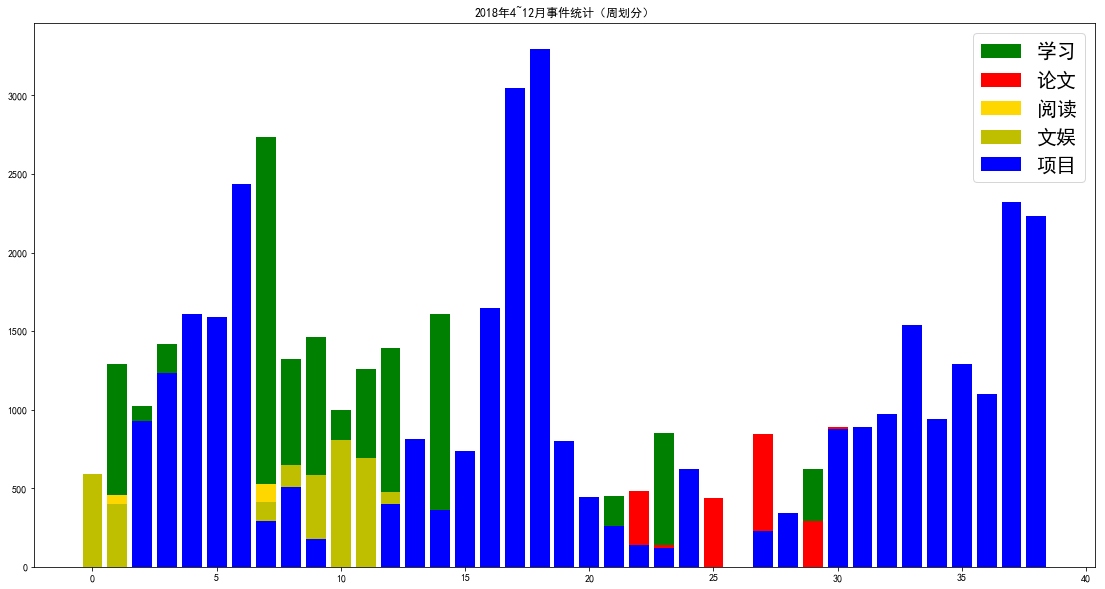

In [201]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
# 中文乱码解决：
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 按周分的条状堆叠图
def proc_wtime(wtime):
    res = {}
    for d in wtime:
        for s in wtime[d]:
            isert(res, s, wtime[d][s])
    return res
def get_wclf_plot(all_log, savepath):# 这里的all_log是基于周的不是纯字典
    colors = {'学习': 'g',
              '论文': 'r',
              '阅读': 'gold',
              '文娱': 'y',
              '项目': 'b'}#,
              #'其他': 'b'}
    plt.figure(figsize=(len(all_log)//2, len(colors)*2))
    plt_x = []
    plt_y = {r: [] for r in colors}
    for w in all_log:
        dct = proc_wtime(all_log[w])
        res = create_rule_clf(dct)
        plt_x.append(len(plt_x))
        for r in colors:
            if r not in res:
                plt_y[r].append(1)
            else:
                plt_y[r].append(res[r])
    idx = np.arange(len(plt_x))
    for ky in plt_y:
        plt.bar(idx, plt_y[ky],
                color=colors[ky], label=ky)
    plt.legend(prop={'size':20})
    plt.title('2018年4~12月事件统计（周划分）')
    plt.savefig(savepath)
get_wclf_plot(wtime,"F:/data/bar.png")

In [203]:
rule_clf = create_rule_clf(all_log) 
for it in rule_clf:
    print(it,rule_clf[it]/60.)

文娱 115.7
阅读 90.36666666666666
其他 443.5
学习 400.65
项目 570.0166666666667
论文 109.0


In [214]:
# 画词云
from wordcloud import WordCloud
import jieba
mytext = ""
for t in all_log:
    if '睡觉' in t:
        continue
    mytext += (' '.join(jieba.cut(t)) + ' ') * all_log[t]

cloud = WordCloud(font_path="F:/data/simhei.ttf",
                  background_color='white',
                  max_words=100,
                  max_font_size=35)
wordcloud = cloud.generate(mytext)

import matplotlib.pyplot as plt
plt.figure(figsize=(25, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("F:/data/wd.png")


In [234]:
def get_code_lines(path):
    import os
    def count_on_file(fname):
        print(fname)
        try:
            rlines = open(fname, encoding='utf-8').readlines()
        except:
            try:
                rlines = open(fname, encoding='gbk').readlines()
            except:
                try:
                    rlines = open(fname).readlines()
                except Exception as e:
                    print("error", e)
                    return 0
            
        ct = 0
        for r in rlines:
            if len(r) > 1:
                ct += 1
        return ct

    endflg = {'.cpp', '.py'}
    res = {k:0 for k in endflg}
    for p, _, fs in os.walk(path):
        for f in fs:
            for e in endflg:
                if f[-len(e):] == e:
                    res[e] += count_on_file(p+'/'+f)
                    break
    return res
res = get_code_lines('C:/code')

C:/code/main.py
C:/code/temp.py
C:/code/temp2.py
C:/code/test (2).py
C:/code\FIS\FIS_keyword_scan\include/device_thread.cpp


C:/code\FIS\FIS_keyword_scan\src/BoolMatchLog.cpp
C:/code\FIS\FIS_keyword_scan\src/BoolParseTree.cpp
C:/code\FIS\FIS_keyword_scan\src/device_lib.py
C:/code\FIS\FIS_keyword_scan\src/device_thread.cpp
C:/code\FIS\FIS_keyword_scan\src/jsoncpp.cpp
C:/code\FIS\FIS_keyword_scan\src/kafka.cpp
C:/code\FIS\FIS_keyword_scan\src/keyword_scan.cpp
C:/code\FIS\FIS_keyword_scan\src/main.cpp
C:/code\FIS\FIS_keyword_scan\src/main_10_31.cpp
C:/code\FIS\FIS_keyword_scan\src/main_11_12.cpp
C:/code\FIS\FIS_keyword_scan\src/temp.cpp
C:/code\FIS\FIS_keyword_scan\src/test.cpp
C:/code\FIS\FIS_keyword_scan\src/test.py
C:/code\FIS\FIS_keyword_scan\src/testUniversalBoolMatch.cpp
C:/code\FIS\FIS_keyword_scan\src/test_json.cpp
C:/code\FIS\FIS_keyword_scan\src/test_kafka.cpp
C:/code\FIS\FIS_keyword_scan\src/test_msgpack.cpp
C:/code\FIS\FIS_keyword_scan\src/UniversalBoolMatch.cpp
C:/code\FIS\FIS_newLogger/complete_alarm_all.py
C:/code\FIS\FIS_newLogger/data_receiver.py
C:/code\FIS\FIS_newLogger/db_sa_mysql.py
C:/code

In [236]:
print(res)

{'.py': 9761, '.cpp': 8524}
